# Fixed particles

## Overview

### Questions

* How can I create arbitrarily shaped barriers?

### Objectives

* Show how to place particles to form arbitrary barriers.
* Demonstrate the technique for HPMC and MD simulations.
    
## Boilerplate code

In [1]:
import hoomd
import gsd.hoomd
import numpy

In [2]:
import os

fn = os.path.join(os.getcwd(), 'initial_state.gsd')
![ -e "$fn" ] && rm "$fn"

The `render` function in the next (hidden) cell will render the system state using **fresnel**. Find the source in the [hoomd-examples](https://github.com/glotzerlab/hoomd-examples) repository.

In [3]:
# This is not intended as a full tutorial on fresnel - see the
# fresnel user documentation (https://fresnel.readthedocs.io/) if you would like to learn more.

import warnings
import math

import fresnel
import IPython
import packaging.version

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

FRESNEL_MIN_VERSION = packaging.version.parse("0.13.0")
FRESNEL_MAX_VERSION = packaging.version.parse("0.14.0")


def render(snapshot):
    if ('version' not in dir(fresnel) or packaging.version.parse(
            fresnel.version.version) < FRESNEL_MIN_VERSION
            or packaging.version.parse(
                fresnel.version.version) >= FRESNEL_MAX_VERSION):
        warnings.warn(
            f"Unsupported fresnel version {fresnel.version.version} - expect errors."
        )
    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(scene,
                                       N=len(snapshot.particles.position),
                                       radius=0.5)
    geometry.material = fresnel.material.Material(color=fresnel.color.linear(
        [252 / 255, 209 / 255, 1 / 255]),
                                                  roughness=0.5)
    geometry.material.primitive_color_mix = 1
    geometry.position[:] = snapshot.particles.position[:]
    typeid = snapshot.particles.typeid
    geometry.color[typeid==1,:] = fresnel.color.linear(
        [90 / 255, 226 / 255, 75 / 255])
    geometry.color[typeid==0,:] = fresnel.color.linear(
        [255 / 255, 154 / 255, 202 / 255])
    
    geometry.outline_width = 0.08
    box = fresnel.geometry.Box(scene, [L, L, 0, 0, 0, 0], box_radius=0.08)

    scene.lights = [
        fresnel.light.Light(direction=(1, 0, 0.4),
                            color=(0.85, 0.85, 0.85),
                            theta=math.pi/2),
    ]
    scene.camera = fresnel.camera.Orthographic(position=(0, 0, L * 2),
                                               look_at=(0, 0, 0),
                                               up=(0, 1, 0),
                                               height=L + 2)
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

## Placing barrier particles

You can create arbitrarily shaped barriers out of particles. This contrived example places particles on a sine wave in a 2D box of length L. You can place particles in whatever geometry you need.

In [4]:
L = 20
N_barrier = 100
x_barrier = numpy.linspace(start=-L/2, stop=L/2, endpoint=False, num=N_barrier)

Choose the period of the sin wave commensurate with the box length:

In [5]:
periods = 2
barrier_amplitude = 4
x_scale = L / (periods * 2 * numpy.pi)
y_barrier = barrier_amplitude * numpy.sin(x_barrier / x_scale)

Place two barriers a given distance apart:

In [6]:
separation = 2
y_barrier_top = y_barrier + separation + barrier_amplitude
y_barrier_bottom = y_barrier - separation - barrier_amplitude

position_barrier_top = numpy.stack((x_barrier, y_barrier_top, numpy.zeros(N_barrier)), axis=-1)
position_barrier_bottom = numpy.stack((x_barrier, y_barrier_bottom, numpy.zeros(N_barrier)), axis=-1)

box_height = barrier_amplitude*4 + separation + 2

## Placing mobile particles

You must place the mobile particles on the correct side of the barrier. This example places all particles on the line `y=0`.

In [7]:
N_mobile = int(numpy.ceil(L/1))
y_mobile = numpy.zeros(N_mobile)
x_mobile = numpy.linspace(start=-L/2, stop=L/2, endpoint=False, num=N_mobile) + 1/2
position_mobile = numpy.stack((x_mobile, y_mobile, numpy.zeros(N_mobile)), axis=-1)

## Combine all particles in the simulation state

Make a GSD file containing all the particles:

In [8]:
frame = gsd.hoomd.Frame()
frame.particles.N = N_mobile + N_barrier * 2
frame.particles.position = numpy.concatenate((position_mobile, position_barrier_top, position_barrier_bottom))

Give the mobile particles and the barrier particles separate types:

In [9]:
frame.particles.types = ['mobile', 'barrier']
frame.particles.typeid = numpy.concatenate((numpy.tile(0, N_mobile), numpy.tile(1, N_barrier), numpy.tile(1, N_barrier)))

Set the box parameters:

In [10]:
frame.configuration.box = [L, box_height, 0, 0, 0, 0]

In [11]:
with gsd.hoomd.open(name='initial_state.gsd', mode='x') as f:
    f.append(frame)

## Perform HPMC simulations with barrier particles

Prepare a simulation of hard disks:

In [12]:
simulation = hoomd.Simulation(device=hoomd.device.CPU(), seed=1)
simulation.create_state_from_gsd(filename='initial_state.gsd')

sphere = hoomd.hpmc.integrate.Sphere()
sphere.shape['mobile'] = dict(diameter=1.0)
sphere.shape['barrier'] = dict(diameter=1.0)
simulation.operations.integrator = sphere

Set the trial move size to 0 so the barrier does not move:

In [13]:
sphere.d['barrier'] = 0

In [14]:
simulation.run(10_000)

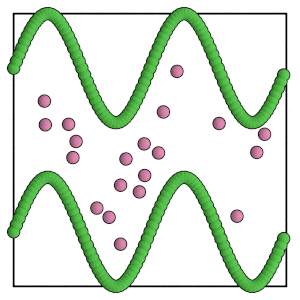

In [15]:
render(simulation.state.get_snapshot())

Carefully choose the move size for the mobile particles. Set the move size too large and a single trial move might pass completely to the other side of the barrier!

## Perform MD simulations with barrier particles

In MD simulations, choose a pair potential interaction with a hard core to prevent the mobile particles from moving through the barrier:

In [16]:
lj = hoomd.md.pair.LJ(nlist=hoomd.md.nlist.Cell(buffer=0.4))
lj.params[('mobile', 'mobile')] = dict(epsilon=1.0, sigma=1.0)
lj.r_cut[('mobile', 'mobile')] = 2.5

lj.params[('mobile', 'barrier')] = dict(epsilon=1.0, sigma=1.0)
lj.r_cut[('mobile', 'barrier')] = 2**(1/6)

Disable barrier-barrier particle interactions:

In [17]:
lj.params[('barrier', 'barrier')] = dict(epsilon=0.0, sigma=0.0)
lj.r_cut[('barrier', 'barrier')] = 0

Integrate the equations of motion of the mobile particles:

In [18]:
langevin = hoomd.md.methods.Langevin(filter=hoomd.filter.Type(types=['mobile']), kT=1.0)

Perform MD simulations:

In [19]:
simulation.operations.integrator = hoomd.md.Integrator(dt=0.001, forces=[lj], methods=[langevin])

In [20]:
simulation.run(10_000)

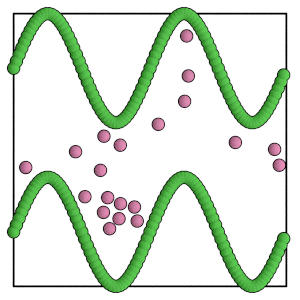

In [21]:
render(simulation.state.get_snapshot())

## Scaling the box

When the barrier is made of particles, operations such as `BoxResize` and `ConstantPressure` can scale the barrier particles along with the mobile particles. Choose the appropriate values for `filter` and `rescale_all` to achieve this behavior.

In [22]:
ramp = hoomd.variant.Ramp(A=0, B=1, t_start=simulation.timestep, t_ramp=20_000)
initial_box = simulation.state.box
final_box = hoomd.Box.from_box(initial_box)
final_box.volume = initial_box.volume / 2
box_resize = hoomd.update.BoxResize(box1=initial_box,
                                    box2=final_box,
                                    variant=ramp,
                                    trigger=hoomd.trigger.Periodic(1),
                                    filter=hoomd.filter.All())
simulation.operations.updaters.append(box_resize)

In [23]:
simulation.run(20_000)

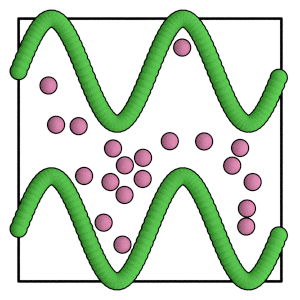

In [24]:
render(simulation.state.get_snapshot())

## Conclusion

This section demonstrated how to use particles to create barriers in the simulation box for both HPMC and MD simulations. The next section explains **wall geometries**, another method to describe barriers.